In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zstandard
from scipy.interpolate import interp1d
import corsika
import logging
import datetime
import sys

#logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# Atmospheres

## Real atmospheres

In [117]:
def InspectModelFit(h, model, cor, title=None):
    fig = plt.figure(figsize=(8,3))
    if title is not None: fig.suptitle(title, fontsize=14)
    ax1, ax2 = fig.subplots(ncols=2, sharey=True)

    ax1.plot(model.temperature(h), h, label='Model')
    ax1.plot(cor.temperature(h), h, label='CORSIKA')
    ax2.plot(model.overburden/cor(h) - 1, h, 'k', label='Model X')
    ax1.set_xlim((200, 300))
    ax2.set_xlim((-0.05, 0.05))

    ax1.legend(loc=0)
    ax2.legend(loc=1)
    ax1.set_ylabel('Altitude (m)')
    ax1.set_xlabel('Temperature (K)')
    ax2.set_xlabel('$P_m/P_\mathrm{ISA} - 1$')

In [161]:
class FFAtmosphere(corsika.Atmosphere):
    """
    From ForeFlight winds aloft data
    """
    def __init__(self, alt, temp, wa, inHg=29.92, h=None):
        super().__init__(h=h, SLP=inHg/29.92*101325)
        # Unit of station altitude is feet(!!)
        self.alt = alt
        iw0 = int(self.alt / 3000.0) + 1
        # Units of h_s is feet
        h_s = np.concatenate((np.array((0, alt), 'd'), np.arange(iw0, 19)*3000.0,
                              np.array((20000, 32000, 47000, 51000, 71000, 85000, 200000), 'd') * 3.28))
        T_s = np.concatenate((np.array((temp+0.001982*alt, temp)), wa,
                              np.array((-56.5, -44.5, -2.5, -2.5, -58.5, -86.3, 1000)))) + 273.16
        self.T_int = interp1d(h_s/3.28, T_s)

    def temperature(self, h):
        return self.T_int(h)

h = np.concatenate((np.arange(0, 30000, 1000), np.arange(30000, 50000, 2500), 
                np.arange(50000, 100000, 5000)))

atms = (
    (20, "ISA", datetime.datetime(1970, 1, 1, 0), 
     "International Standard Atmosphere",
     corsika.ISA(h)),

    (21, "KMCI", datetime.datetime(2023, 11, 20, 9), 
     "Atmosphere as predicted 3:00 am CST Nov 20 2023 over Kansas City (KMCI)",
     FFAtmosphere(h=h, alt=1027., temp=9., inHg=29.91, wa=np.array((
         3,   1,  -2,  -5, -10, -16, -23, -31, -38, 
         -47, -52, -51, -48, -49, -51, -53, -54, -56)))),
    
    (22, "KMSN", datetime.datetime(2020, 7,7), 
     "Atmosphere over MSN 07/07/2020",
     FFAtmosphere(h=h, alt=928., temp=26., inHg=29.97, wa=np.array((
         22,  16,   9,   3,  -2,  -7, -13, -19, -26, 
         -32, -40, -46, -51, -56, -61, -63, -65, -65)))),

    (23, "KMDT", datetime.datetime(2023, 11, 21, 23), 
     "Atmosphere over Harrisburg, PA on Nov 21 2023",
     FFAtmosphere(h=h, alt=310., temp=7., inHg=30.07, wa=np.array((
         5,   4,   0,  -3,  -7, -13, -19, -26, -33,
         -42, -49, -56, -60, -60, -59, -59, -59, -59)))),
    
    (24, "KLRD", datetime.datetime(2023, 11, 22, 13), 
     "Laredo, TX Nov 22 2023 1300Z",
     FFAtmosphere(h=h, alt=508., temp=6.,inHg=30.36, wa=np.array((
         6, 3, 2, -1, -6, -11, -18, -25, -31, -38,
         -43, -50, -56, -57, -59, -62, -65, -67)))),
                   
    (25, "KICT", datetime.datetime(2023, 11, 25, 21),
     "Wichita, TX Nov 25 2023 2100Z",
     FFAtmosphere(h=h, alt=1333., temp=-2., inHg=30.23, wa=np.array((
         -3, -2, -4, -7, -13, -19, -26, -34, -40, -47, 
         -50, -51, -51, -53, -55, -57, -59, -61)))),

    (26, "CYBC", datetime.datetime(2023, 11, 27, 17, 30),
     "Baie-Comeau, CA Nov 27 2023 1730Z",
     FFAtmosphere(h=h, alt=71, temp=1.0, inHg=29.48, wa=np.array((
         -2, -7, -8, -10, -16, -21, -28, -37, -44, -48, 
         -54, -55, -53, -53, -53, -54, -55, -56)))),

    (27, "KEYW", datetime.datetime(2023, 11, 28, 3), 
     "Key West, FL Nov 28 2023 0300Z",
     FFAtmosphere(h=h, alt=3, temp=24., inHg=30.08, wa=np.array((
         17, 14, 10, 4, 0, -6, -11, -18, -25, -32, -39, 
         -47, -55, -61, -67, -71, -74, -76))))
    )

isa = atms[0][4]

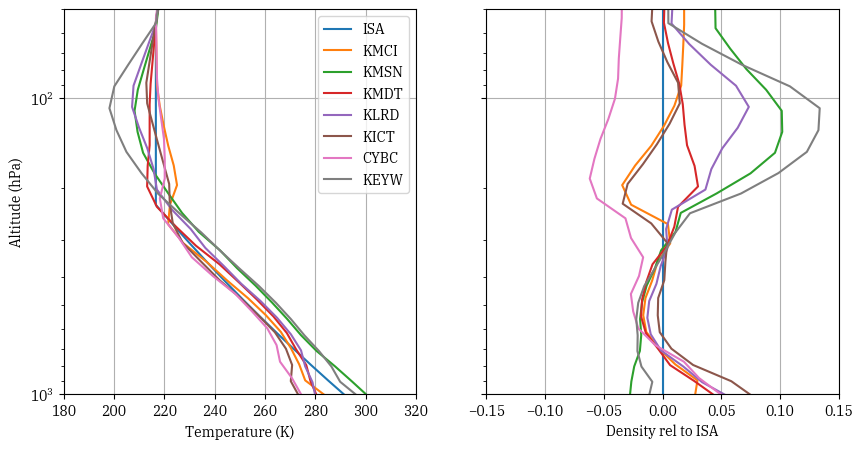

In [164]:
fig, (axT, axD) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axT.set_xlabel('Temperature (K)')
axT.set_ylabel('Altitude (hPa)')
formats = ("k-", "b")
for bern, st_id, dt, desc, a in atms:
    axT.semilogy(a.temperature(a.h), a.pressure/100, label=st_id)

    relD = (a.density - isa.density) / isa.density
    axD.semilogy(relD, a.pressure / 100)
    axD.set_xlim(-0.15, 0.15)
    axD.set_xlabel('Density rel to ISA')

axT.axis((180, 320, 1000, 50))
axT.legend()

## Bernlohr Stuff

In [4]:
def vapor_pressure(t, RH):
    K = np.array((1.16705214528E+03,
        -7.24213167032E+05,
        -1.70738469401E+01,
        1.20208247025E+04,
        -3.23255503223E+06,
        1.49151086135E+01,
        -4.82326573616E+03,
        4.05113405421E+05,
        -2.38555575678E-01,
        6.50175348448E+02))
    
    T = t + 273.15
    W = T + K[8]/(T - K[9])
    A = W**2 + K[0]*W + K[1]
    B = K[2]*W**2 + K[3]*W + K[4]
    C = K[5]*W**2 + K[6]*W + K[7]
    X = -B + np.sqrt(B**2 - 4*A*C)
    p_sv = 1E6*(2*C/X)**4
    return RH / 100 * p_sv
    
def edlen(p, t, RH, wavelength=0.5):
    A = 8342.54
    B = 2406147.
    C = 15998.
    D = 96095.43
    E = 0.601
    F = 0.00972
    G = 0.003661
    S = wavelength**-2
    n5 = 1.0 + 1E-8*(A + B/(130-S) + C/(38.9-S))
    X = (1 + 1E-8*(E - F*t)*p)/(1+G*t)
    n_tp = 1 + p*(n5 - 1)*X/D
    return n_tp - 1E-10*(292.75/(t + 273.15))*(3.7345 - 0.0401*S)*vapor_pressure(t, RH)


In [65]:
for bern, st_id, dt, desc, a in atms:
    with open(f"atmprof{bern}.dat", "wt") as f:
        print("# " + desc, file=f)
        print("# Alt [km]  rho [g/cm^3] thick [g/cm^2]    n-1", file=f)
        for alt, rho, p in zip(a.h, a.density, a.pressure):
            n = edlen(p, a.temperature(alt)-273.1, 50)
            n -= 1
            n = max(n, 0.5E-11)
            thick = p / 100
            print(f"{alt*0.001:10.3f} {rho*0.001:12.5e} {thick:12.5e} {n:12.5e}", file=f)

In [22]:
co = np.array(((-173.255, 1186.51, 9941.86),
               (-94.4369, 1128.91, 8781.54),
               (0.399165, 1283.13, 6361.43),
               (-2.07766E-03, 525.5, 7636.13))).T

bernISA = corsika.CORSIKAAtmosphere(
    layers=np.array((0, 6, 9.75, 42.5, 95))*1E3,
    par=co)

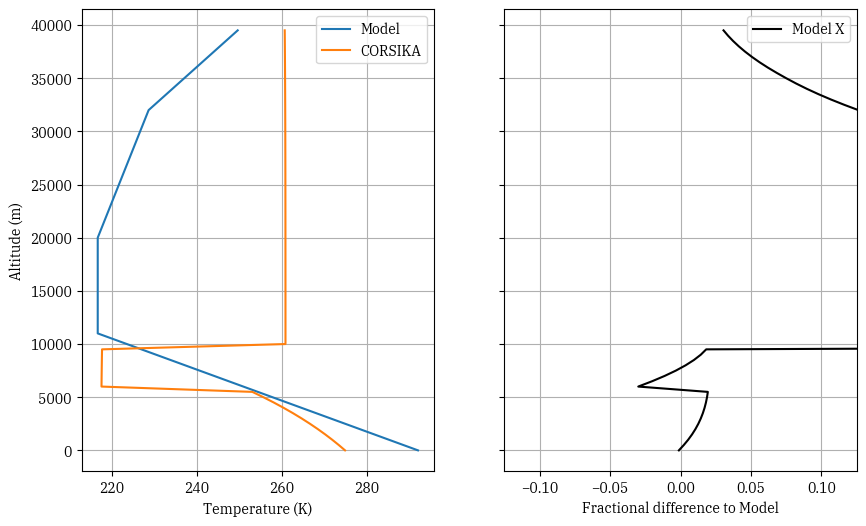

In [25]:
h = np.arange(0, 40000, 500)
isa.h = h
InspectModelFit(h, isa, bernISA)

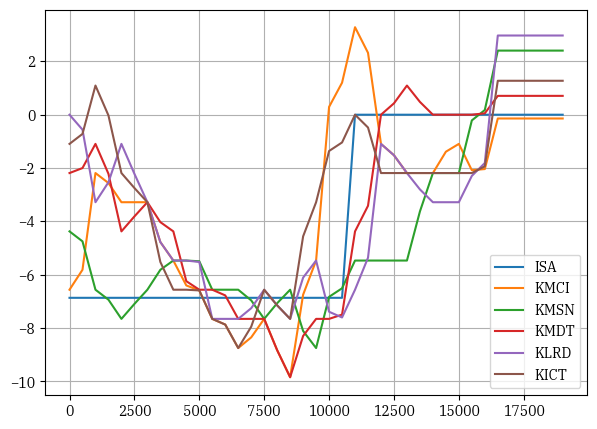

In [102]:
for bern, st_id, d, desc, a in atms:
    plt.plot(alt[:-1], 2*np.diff(a.temperature(alt)), label=st_id)

plt.legend()

## CORSIKA Atmosphere Fitting

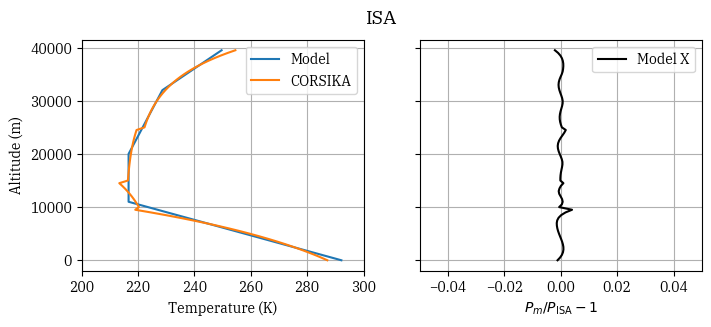

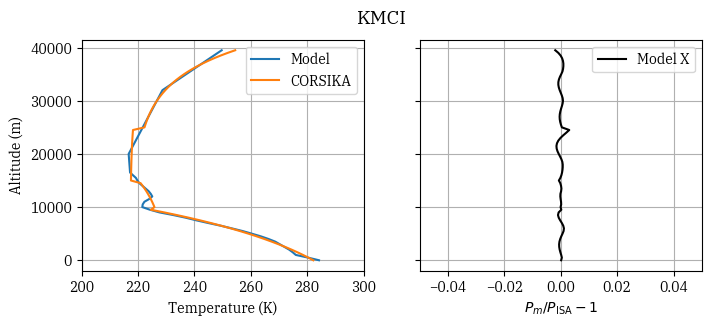

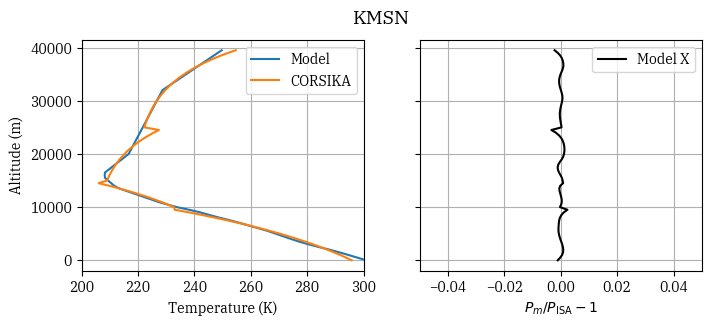

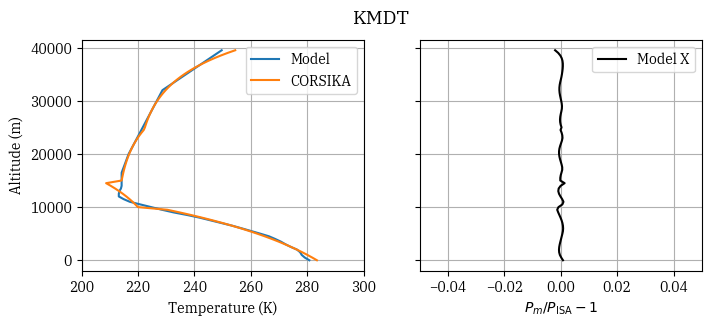

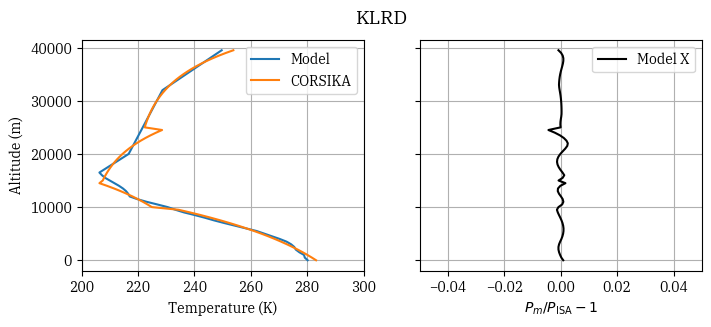

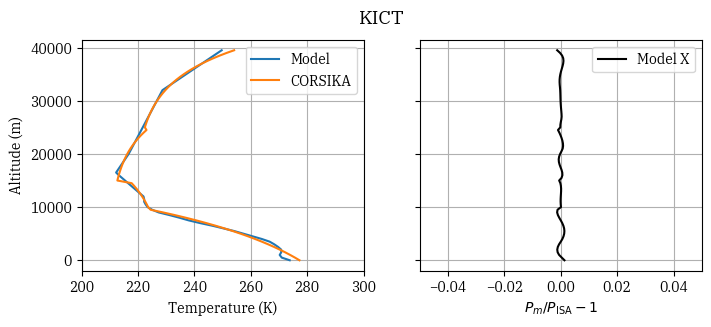

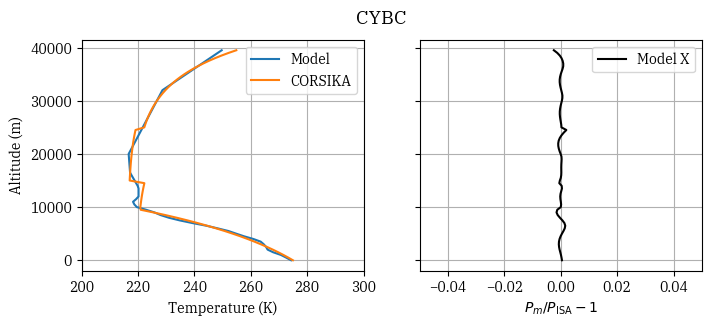

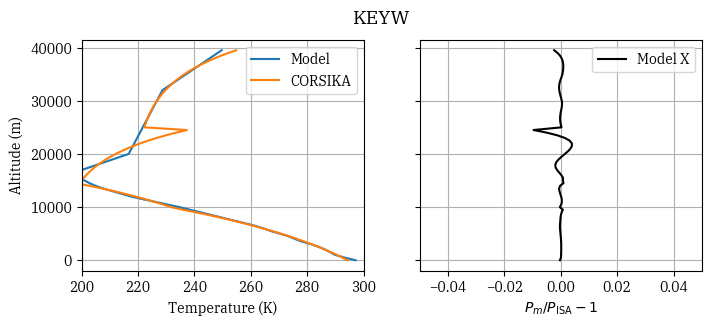

In [165]:
for bern, st_id, dt, desc, a in atms:
    a.h = np.array((10000, 15000, 25000, 40000), 'd')
    corFIT = corsika.CORSIKAAtmosphere.fitToAtmosphere(a)
    h = np.arange(0, 40000, 500)
    a.h = h
    corFIT.improveFit(a)
    InspectModelFit(h, a, corFIT, title=st_id)

In [122]:
atms[6:]

((26,
  'CYBC',
  datetime.datetime(2023, 11, 27, 17, 30),
  'Baie-Comeau, CA Nov 27 2023 1730Z',
  <__main__.FFAtmosphere at 0x7fcf876dded0>),)

In [135]:
cards = """RUNNR   {run}
EVTNR   1
SEED    {seed[0]} 0 0
SEED    {seed[1]} 0 0
SEED    {seed[2]} 0 0
NSHOW   100000
PRMPAR  14
ELMFLG  T F
STEPFC  1.0
QGSJET  T   0
URQMD   T   0
THETAP  {theta:.1f} {theta:.1f}
ERANGE  25.0 50000.0
ESLOPE  -2.0
PAROUT  T F
ECTMAP  1000
DIRECT  /home/kael/stratoverse/corsicast/data/
DEBUG   F 6 F 0
ATMOD   0"""

for bern, st_id, dt, desc, a in atms:
    for theta in np.array((0.0, 15.0, 30.0, 45.0, 60.0)):
        run = bern*10000 + int(theta)*100 + 2
        seed = np.random.randint(low=1000000, high=2000000, size=3)
        a.h = np.array((10000, 15000, 25000, 40000), 'd')
        corFIT = corsika.CORSIKAAtmosphere.fitToAtmosphere(a)
        h = np.arange(0, 40000, 500)
        a.h = h
        corFIT.improveFit(a)
        with open(f"ATM{run}{st_id}.in", "wt") as f:
            print(cards.format(run=run, seed=seed, theta=theta), file=f)
            print(corFIT.ATMA, file=f)
            print(corFIT.ATMB, file=f)
            print(corFIT.ATMC, file=f)
            print("EXIT", file=f)
    run += 1

# Analysis

In [44]:
def ehist(filename, bins=None):
    energy = []
    with open(filename, "rb") as f:
        z = zstandard.ZstdDecompressor()
        r = corsika.CORSIKAReader(z.stream_reader(f))
        for evt in r:
            for p in evt.part:
                energy.append(np.sum(p.p**2)**0.5)
    if bins is None: bins=np.arange(0, 50)
    return np.histogram(energy, bins=bins)

In [136]:
bins = np.concatenate((np.arange(0, 10), np.arange(10, 20, 2), np.arange(20, 100, 5)))
spec = np.zeros((7, 5, len(bins)-1), 'd')
for ib in range(20, 27):
    for it in range(0, 5):
        filename = f'data/DAT{ib:02d}{it*15:02d}02.zst'
        spec[ib-20,it] = ehist(filename, bins=bins)[0]

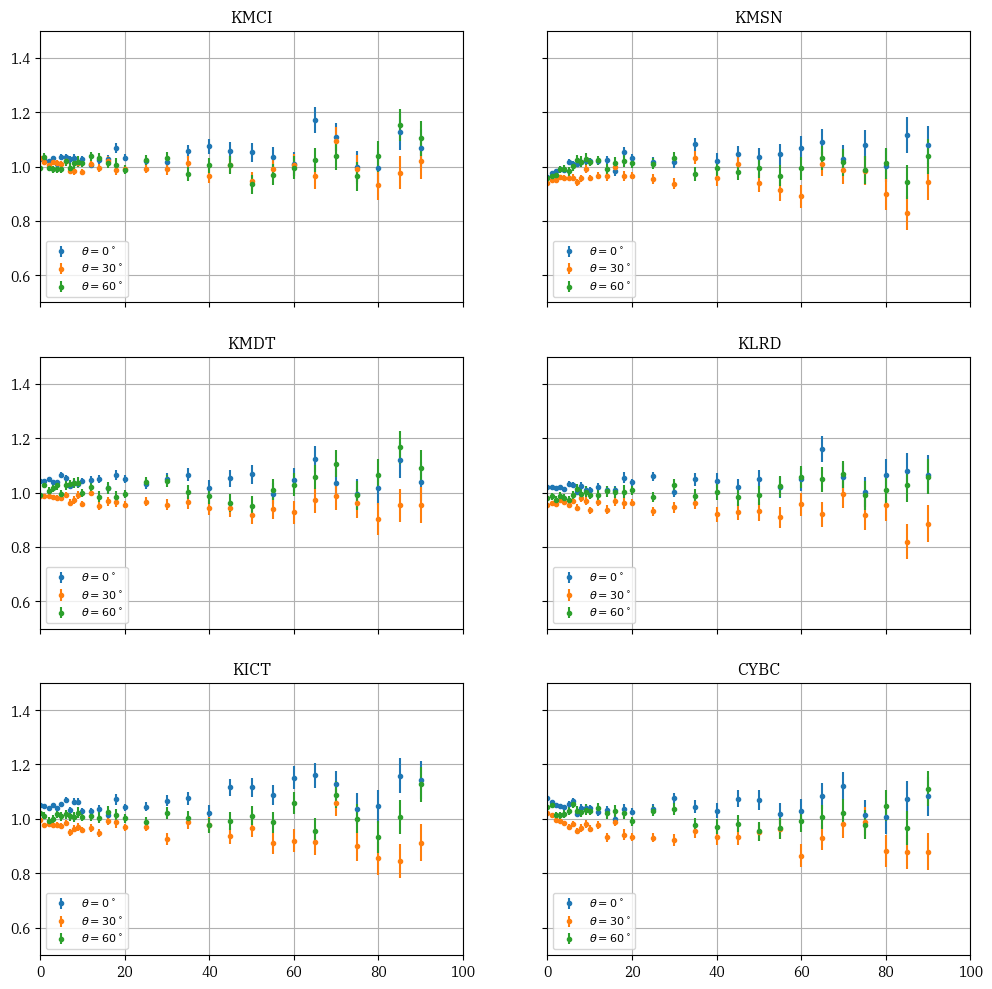

In [137]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12,12))
axs = axs.flatten()

for i in range(6):
    for j in (0, 2, 4):
        N0 = spec[0,j]
        N1 = spec[i+1,j]
        relflux = N1 / N0
        rferror = np.sqrt(1/N1 + 1/N0)
        axs[i].errorbar(bins[:-1], relflux, yerr=rferror, fmt='.', label=f'$\\theta={j*15}^\circ$')
        axs[i].legend(loc=3, fontsize=8)
        axs[i].axis((0, 100, 0.5, 1.5))
        axs[i].set_title(atms[i+1][1])

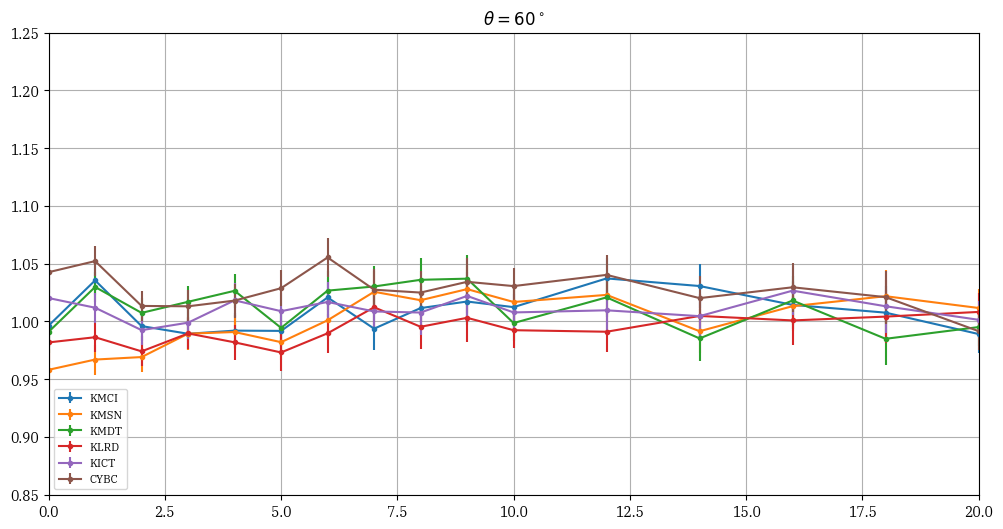

In [160]:
plt.figure(figsize=(12,6))
j = 4
for i in range(6):
    N0 = spec[0,j]
    N1 = spec[i+1,j]
    relflux = N1 / N0
    rferror = np.sqrt(1/N1 + 1/N0)
    plt.errorbar(bins[:-1], relflux, yerr=rferror, fmt='.-', label=atms[i+1][1])
    plt.legend(loc=3, fontsize=8)
    plt.axis((0, 20, 0.85, 1.25))
    plt.title(f'$\\theta={j*15}^\circ$')